# Golden redfish in Icelandic waters: a statistical approach

# Software and data

## Packages imported

This file contains the python code and description of the Golden redfish statistical model that Maris Optimum has developed.

Sources:
<ol>
    <li>Data from Icelandic Marine and Freshwater Institute (IMFI) </li>
    <li>Data from the Directory of Fisheries (DF) obtained from IMFI</li>
    <li>Gradient boosting regression algorithm xgboost and various packages</li>
    <li>Python 3.11 programming language</li>
</ol>
    
    
The main packages used are:
    [the xgboost regressor](https://xgboost.readthedocs.io/en/stable/index.html), 
    [the scikit-learn suite ](https://scikit-learn.org/stable/user_guide.html),
    [the shap suite](https://shap.readthedocs.io/en/latest/index.html).
    
We start by describing the data gathering and the functions of the model.


In [1]:
"""Optimal regression found to estimate catch sizes."""


import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
import time

path_str = 'R:\\Ráðgjöf\\Maris Optimum/gr_data\\'
# path_str = ''
path_grs_weight =\
    'R:/Ráðgjöf/Maris Optimum/Data_from_Hafro_20220906/ssb_weights/'

red_length_weights = pd.read_csv(
    path_grs_weight + "red_length_weights.csv")
red_length_weights.set_index('ar', inplace=True)

## Data Fetched and adjusted

### Data

In [2]:
def get_new_data(fractile, show_heatmaps):
    """
    Fetch all data for the regression.

    Parameters
    ----------
    fractile : integer.

    Returns
    -------
    XX_df : Dataframe with data for all the dependent variables.
    YY : Dataframe with data for the the independent variable.

    """
    X100_df = pd.read_csv(path_str + 'distribution100.csv',
                          sep=",")
    ysq_df = X100_df[['ar', 'max(cum)']].copy()
    ysq_df.set_index(['ar'], inplace=True)
    ysq_df = ysq_df[~ysq_df.index.duplicated(keep='first')]

    X_df = pd.read_csv(path_str + 'distribution' + fractile + '.csv',
                       sep=",")

    catch_df = pd.read_csv(path_str + 'golden_redfish_catch.csv',
                           sep=";")

    catch_df.at[37, 'year'] = 2022.0
    catch_df.at[37, 'catch'] = 26
    catch_df.at[37, 'number'] = 29

    X_cal_df = pd.read_csv(path_str + 'distribution_commercial.csv',
                           sep=",")
    X_cal_df.drop(1605, axis=0, inplace=True)

    X_cal_df = X_cal_df.pivot(index='ar',
                              columns='lengd',
                              values='per_length')
    X_cal_df = X_cal_df.fillna(0)
    X_cal_df.columns = 1000 + X_cal_df.columns
    X_cal_df.columns = X_cal_df.columns.astype(int).astype(str)

    catch_df = catch_converter(X_cal_df, catch_df, show_heatmaps)
    catch_df.year = catch_df.year.astype(int)
    catch_df.set_index(catch_df.year, inplace=True)

    X_cal_df = X_cal_df.mul(catch_df.number*-1e6, axis=0)

    XX_df = X_df.pivot(index='ar',
                       columns='lengd',
                       values='per_length')

    XX_df = pd.merge(XX_df, ysq_df, right_index=True, left_index=True)

    XX_df.drop(11.9, axis=1, inplace=True)
    XX_df.drop(12.5, axis=1, inplace=True)
    XX_df.drop(12.6, axis=1, inplace=True)
    XX_df.drop(13.1, axis=1, inplace=True)
    XX_df.drop(13.4, axis=1, inplace=True)
    XX_df.drop(13.6, axis=1, inplace=True)
    XX_df.drop(13.7, axis=1, inplace=True)
    XX_df.drop(13.9, axis=1, inplace=True)
    XX_df.drop(14.4, axis=1, inplace=True)
    XX_df.drop(14.5, axis=1, inplace=True)
    XX_df.drop(14.7, axis=1, inplace=True)
    XX_df.drop(14.8, axis=1, inplace=True)
    XX_df.drop(14.9, axis=1, inplace=True)

    XX_df.columns = XX_df.columns.astype(str)

    YX = pd.read_csv(path_str+"RED_numbers_at_age.csv", sep=";")
    YY = YX.iloc[15:53, 28]

    XX_df = XX_df.join(X_cal_df.iloc[:, :])

    XX_df.index = XX_df.index.astype(str)

    s = XX_df.index[27:35]
    s.index = XX_df[27:35]
    s = pd.get_dummies(s)
    s.index = XX_df.index[27:35]
    XX_df = XX_df.join(s)

    XX_df = XX_df.fillna(0)
    if show_heatmaps:
        heat_maps(XX_df,YY)
    return (XX_df, YY)

### Conversion of kg catch to units of individuals in length groups

The annual catch of the fleet is reported by weight. The statistical model is based on number of individuals at each length cm. Measurement data from IMFI surveys was employed to estmate the catch into lengths and number of individuals. 

Where data did not exist polynomial regression of the second order was employed to estmiate lengths and weights.

In [3]:
def catch_converter(X_catch_per_df, catch_df, show_heatmaps):
    """
    Catch information used to formulate and calculate units from kg.

    Parameters
    ----------
    X_catch_per_df : Dataframe containing percentages of catch.
    catch_df : Dataframe containing total cath in kg.

    Returns
    -------
    catch_df : Dataframe containing total catch in lengths.
    """
    path_grs_str = 'R:/Ráðgjöf/Maris Optimum/Golden_redfish_model/'
    path_grs_weight =\
        'R:/Ráðgjöf/Maris Optimum/Data_from_Hafro_20220906/ssb_weights/'

    red_length_weights = pd.read_csv(
        path_grs_weight + "red_length_weights.csv")
    red_length_weights.set_index('ar', inplace=True)

    wl_df = pd.read_csv(path_grs_str+'RED_gadget_n_at_age.csv', sep=',')

    Xl = wl_df[['year', 'mean_length']].copy()
    yl = wl_df[['year', 'mean_weight']].copy()

    for index, row in Xl.iterrows():
        Xl.at[index, 'squared'] = row[1]**2

    for year in range(1985, 2022):
        average_weight = 0
        reg_X = Xl[Xl['year'] == year]
        reg_y = yl[yl['year'] == year]
        reg = LinearRegression().fit(
            reg_X[['mean_length', 'squared']], reg_y[['mean_weight']])
        b = reg.coef_[0][0]
        a = reg.coef_[0][1]
        c = reg.intercept_
        for col in range(1020, 1060):
            if year > 1995 and \
               pd.isna(red_length_weights.loc[year, str(col-1000)]) is False:
                average_weight += red_length_weights.loc[year, str(col-1000)]
            else:
                average_weight += (X_catch_per_df.loc[year, str(col)]) * (
                    a*(col - 1000)**2 + b*(col - 1000) + c)
        catch_df.at[
            year - 1985, 'number'] = catch_df.loc[
                year - 1985, 'catch']/average_weight

    if show_heatmaps:
        df = red_length_weights
        scaled_df = (df - df.min(axis=0))/(df.max(axis=0) - df.min(axis=0))
        fig, ax = plt.subplots(figsize=(8,6))
        ax = sns.heatmap(scaled_df, linewidths=.5, cmap='RdYlGn')
        ax.set(ylabel='year')
        plt.show()
    return catch_df

The data used was received from the Icelandic Marine and Freshwater Institute spring surveys and catch reports by the Directorate of Fisheries (DF). We have modified the survey data as large individual hauls may have undue influence on the overall samples and give a biased view of the size distribution in the survey. The relatitve importance of the largest catches has been scaled down to the size of the catch sizes at the 96th fractile to reduce this bias.  See appendix 1 for more detail.

The regression is set up in the normal fashion: y = f(X), where y, the independant variable is the stock index and X, the dependent variable ("features") is the set of observation and f is a function derived from the regression.

X contains 108 variables. The first 51 are taken directly from every spring survey from 1985 and are the calculated percentage of individuals that appear in each  length group. The following variable is, max(cum), is the number of individials observed in the survey. 

The next five variables are slack variables for years 2015 - 2019.

The final 51 variables contain the number of individuals observed in each length group by the fishing fleet as collected by the DF.

# Plots and Figures

### Heat maps

In [4]:
def heat_maps(X, y):
    """
    Plot heatmaps.

    Parameters
    ----------
    X : Independent variables.
    y : Dependent variables.

    Returns
    -------
    Pictues of heat maps.

    """
    fig, ax = plt.subplots(figsize=(8,6))
    sns.color_palette("vlag", as_cmap=True)
    ax = sns.heatmap(X.iloc[:, :50], cmap='RdYlGn')
    ax.set(ylabel='year')
    
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap((
        y.to_numpy() * X.iloc[:, 0:50].T).T, cmap='RdYlGn')
    ax.set(ylabel='year')
    plt.show()

### Plot over possible stock range

The algorithm iterates over the range 343 to 453 million individuals in steps of one million individuals at a time. It finds the lowest mean absolute error at each step. The plot shows the mean absolute error and $r^2$.

In [5]:
def plot_result_range(result_dict, interval_int, fractile, y_offset):
    """
    Plot mae and r^2 for the range of the looped regression.

    Parameters
    ----------
    result_dict : a dictianary containing the results from different regression
    over the interval.
    interval_int : integer with the increments used over the interval.
    fractile : fractile used for Winsorization.


    Returns
    -------
    None.

    """
    result_dict['x'] = list(range(343+y_offset,
                             453+y_offset,
                             int(interval_int/1e6)))
    fig, ax = plt.subplots()
    sns.set(style='whitegrid',
            palette='pastel', )
    sns.lineplot(x='x',
                 y='r2',
                 data=result_dict,
                 color="red",
                 ax=ax)
    ax.set(xlabel='size of stock in millions',
           ylabel='r2, red',
           title='school fractile:'+fractile+'\n'
           + '1985-2022',
           ylim=(0, 1))

    ax2 = ax.twinx()
    sns.lineplot(x='x',
                 y='mae',
                 data=result_dict,
                 color='blue',
                 markers=True, ax=ax2)
    ax2.set(ylabel='mean average error, blue')
    plt.show()


### Shap calculations and plots

Shap [values](https://github.com/slundberg/shap) are calculated for the values with the lowest mean absolute error. The twenty most influential feaures are displayed. As there is a strong degree of dependency between the features (see Appendix 2 below) care must be applied to the analysis (see for example this article: [The limitations of shap](https://towardsdatascience.com/the-limitations-of-shap-703f34061d86#:~:text=But%20don't%20let%20the%20popularity%20persuade%20you.&text=We%20will%20discuss%203%20significant,them%20%E2%80%94%20we%20make%20up%20stories)).

In [6]:
def shap_calculations_xgb(regressor, XX_df):
    """
    Calculate shap vales for the xgb_regressor and the dependant variables.

    Parameters
    ----------
    regressor : TYPE
        DESCRIPTION.
    XX_df : TYPE
        DESCRIPTION.

    Returns
    -------
    Importance plot and waterfall plot

    """
    
    fig = plt.figure()
    fig.set_figheight(5)
    explainer = shap.TreeExplainer(regressor)

    shap_values = explainer.shap_values(XX_df)

    shap.summary_plot(shap_values,
                      XX_df,
                      plot_type="violin",
                      max_display=15,
                     show=False)
    
    plt.gcf().set_size_inches(8,6)
    plt.show()
    

    shap_values = explainer(XX_df)
    shap.plots.waterfall(shap_values[37], 
                         max_display=15,
                         show=False)
    
    plt.gcf().set_size_inches(8,6)
    plt.show()

### Regression over possible ending values of stock

The algorithm itearates over the range 343 to 453 million individuls in steps of one 1 million at a time. It finds parameters for the gradient boosting algorithm by using grid search where the root mean square error is as low as possible at each step. 
It choses the number of individuals based on the lowest mean absolute error value.

In [7]:
def regression_over_possible_values_XGB(X, y, interval_int):
    """
    Loop over possible stock sizes, regressing in every step.

    Parameters
    ----------
    X : Dataframe with dependent variables.
    y : Dataframe with independent variables.
    interval_int : step interval.


    Returns
    -------
    result_dict : json string with solutions in each interval.

    """
    parameters = {
        'eval_metric': ["mae"],
        'learning_rate': [.01, .05, .1, .2, .3],
        'max_depth': [2],
        'min_child_weight': [2],
        'subsample': [.5],
        'colsample_bytree': [.5],
        'n_estimators': [120]
    }
    test_size = .25
    seed = 5
    result_dict = {'fjoldi2022': [], 'fjoldi2021': [],
                   'fjoldi2020': [], 'mae': [], 'rmse': [], 'r2': [],
                   'evs': []}

    xgb1 = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

    for add_int in range(0, 110000000, interval_int):
        # print(add_int)

        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=test_size,
            random_state=seed)

        n_iter = 200
        n_iter = n_iter

        xgb_regressor = GridSearchCV(xgb1,
                                     parameters,
                                     n_jobs=-1,
                                     cv=3,
                                     verbose=False)

        eval_set = [(X_train, y_train), (X_test, y_test)]

        xgb_regressor.fit(X_train,
                          y_train,
                          eval_set=eval_set,
                          verbose=False)

        y_pred_test = xgb_regressor.predict(X_test)

        # y_pred_test = svr_regression(X_train, y_train, X_test, y_test)

        result_dict['fjoldi2022'].append(y.iloc[37])
        result_dict['fjoldi2021'].append(y.iloc[36])
        result_dict['fjoldi2020'].append(y.iloc[35])

        result_dict['mae'].append(mean_absolute_error(y_test,
                                                      y_pred_test))
        result_dict['rmse'].append(math.sqrt(mean_squared_error(y_test,
                                                                y_pred_test)))
        result_dict['r2'].append(r2_score(y_test,
                                          y_pred_test))
        result_dict['evs'].append(explained_variance_score(y_test,
                                                           y_pred_test))
        y.iat[35] += interval_int * (y.iloc[35]/y.iloc[36])
        y.iat[36] += interval_int * (y.iloc[36]/y.iloc[37])
        y.iat[37] += interval_int

    min_value = min(result_dict['mae'])
    min_index = result_dict['mae'].index(min_value)

    y.iat[35] = result_dict['fjoldi2020'][min_index]
    y.iat[36] = result_dict['fjoldi2021'][min_index]
    y.iat[37] = result_dict['fjoldi2022'][min_index]

    regressor = GridSearchCV(xgb1,
                             parameters,
                             n_jobs=-1,
                             cv=3,
                             verbose=0)

    regressor.fit(X, y)
    params = regressor.best_params_
    regressor = xgb.XGBRegressor(**params)
    regressor.fit(X, y)


    return result_dict, regressor

### Free regression (with slack variables for the period 2015 to 2019)

In [8]:
def free_regression_XGB(X, y):
    """
    Regression where part of y values are free.

    Parameters
    ----------
    X : Dataframe with dependent variables.
    y : Dataframe with independent variables.

    Returns
    -------
    returns array with predection for y based intiial values of X and
    the regression.

    """
    parameters = {
        'eval_metric': ["mae"],
        'learning_rate': [0.01, 0.1],
        'max_depth': [2],
        'min_child_weight': [2],
        'subsample': [.5],
        'colsample_bytree': [.5],
        'n_estimators': [120]
    }

    seed = 5

    xgb1 = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

    year = 29

    X_train = pd.concat([X.iloc[:year, :], X.iloc[34:, :]])
    y_train = pd.concat([y.iloc[:year], y.iloc[34:]])
    # print(y_train)
    X_test = X.iloc[year:34, :]
    y_test = y.iloc[year:34]

    n_iter = 200
    n_iter = n_iter

    eval_set = [(X_train, y_train), (X_test, y_test)]

    regressor = GridSearchCV(xgb1,
                             parameters,
                             n_jobs=-1,
                             cv=3,
                             verbose=0)

    regressor.fit(X_train,
                  y_train,
                  eval_set=eval_set,
                  verbose=0)

    # params = regressor.best_params_
    # regressor = xgb.XGBRegressor(**params)
    # regressor.fit(X_train, y_train)

    return regressor.predict(X)

## Model run (#1)


  1. Adjusted data fetched
  2. Heat maps generated
  3. Regression in a loop over possible values 

  



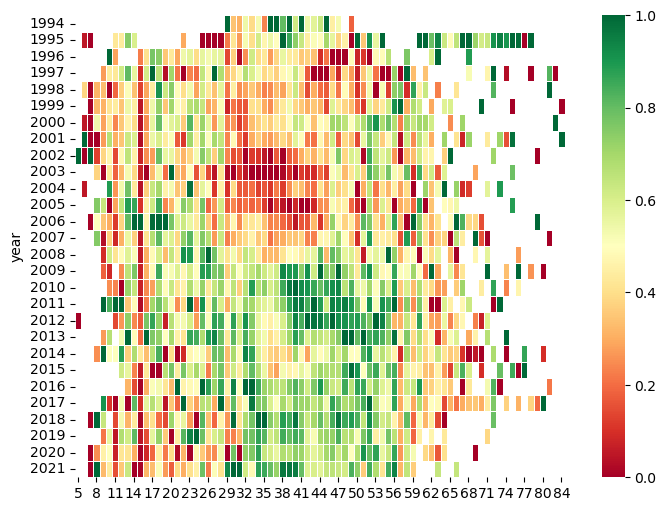

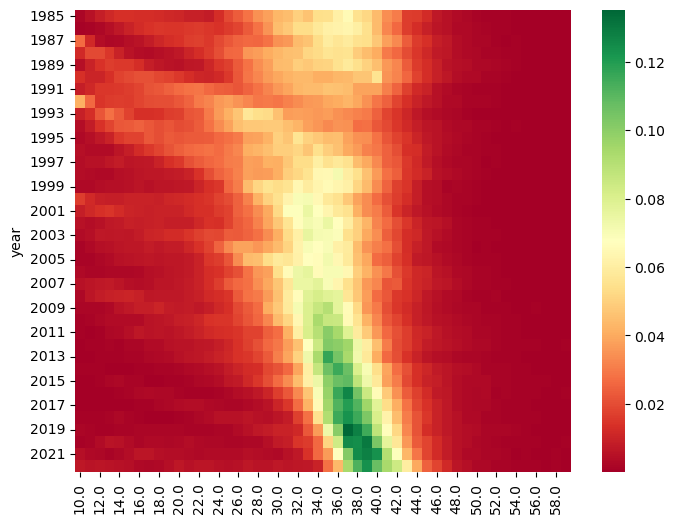

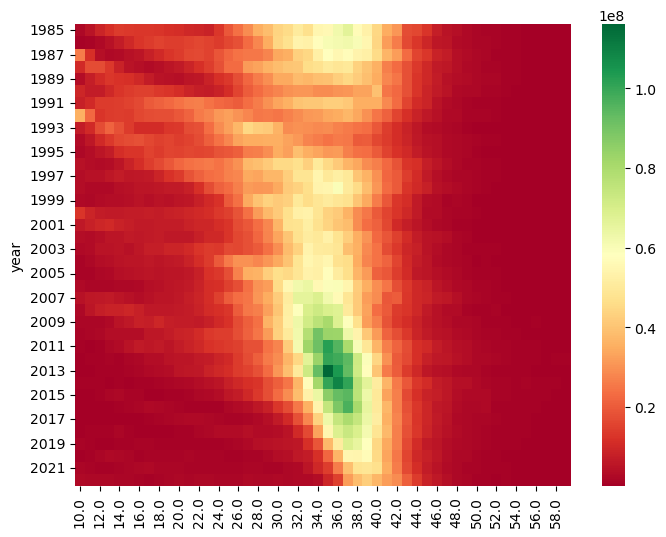

In [9]:
fractile = '096'
interval_int = 1000000

(X, y) = get_new_data(fractile, show_heatmaps=True)

Above there are three heatmaps.
in the first heat map we show the relative weight of individuals of certain length over the years. We compared the mean weight for individuals of lengths from 30-50cm for the years in this decade to the mean of the average weights of the whole population sample. Interestingly they differ significantly at the α=.01 level. 

The other two heat maps show the distribution of the length classes in percentages and millions. They show really well the precarious position of the golden redfish stock.

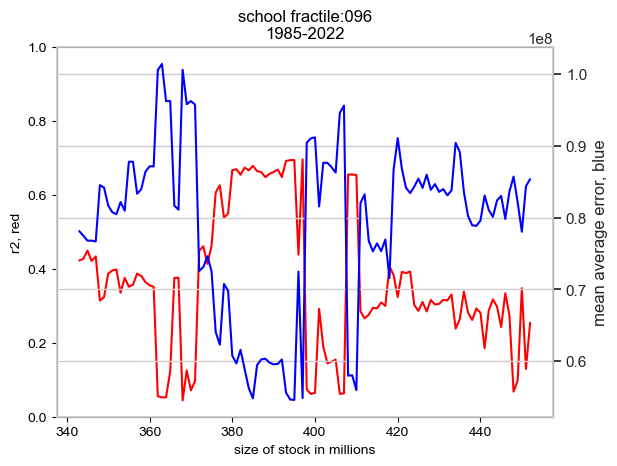

In [10]:
result_dict_gb, regressor = regression_over_possible_values_XGB(X, y, interval_int)
plot_result_range(result_dict_gb, interval_int, fractile, 0)

The optimal solutions (the solutions that best balance the mean bsolute error ("mae") and the explainability ($r^2$) ) is that there are currently 385, 395 or 412 m individuals in the stock. At this point mae $\approx$ 52m individuals and $r^2$ $\approx$ 0.55. While this is a solid estimate we are looking for a better result in terms of r2 og mae. 

## Model run (#2)


  1. Adjusted data fetched
  3. "Free" gradient boosting used to estimate actual stock sizes for 2015-2019
  4. Regression in a loop over possible values 
  5. Shap analysis
    


In [11]:
(X_observed, y_observed) = get_new_data(fractile, False)
y_2022 = y_observed.iloc[37]

y_calculated = pd.Series(free_regression_XGB(X_observed, y_observed))
y_offset = int((y_calculated.iloc[37]-y_2022)/1e6)
result_dict_gb, regressor = regression_over_possible_values_XGB(X_observed,
                                                     y_calculated,
                                                     interval_int)


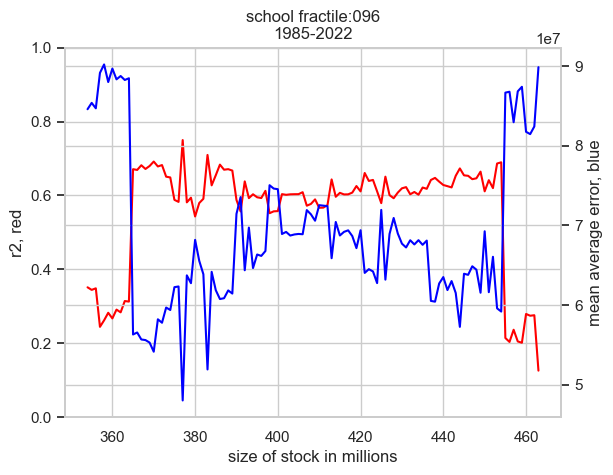

In [12]:
plot_result_range(result_dict_gb,
                  interval_int,
                  fractile,
                  y_offset)
                            

Given the rapid decline in stocks in the past few years we were keen to test if the estimates of stock sizes in the past decade may have been excessive. By introducing slack variables for the years 2015 - 2019 and fixing the test on the same period as well as fixing the result of the last 3years we got a much better result. In this case the current stock size was estimated at 378 m individuals. At this point mae $\approx$ 47m individuals and $r^2$ $\approx$ 0.8.

This result is much better than the previous instance. The result of IMFI of 343 m individuals falls within the confidence interval so the results are essentially the same.

In the table below we show the difference between the observed stock size and the size as calculated by the model: 


In [13]:
y_observed.index=range(0,38)
y_df = pd.concat([y_observed, y_calculated], axis=1, join='inner')
y_df.columns = ['observed', 'calculated']
y_df['difference'] = y_df['observed'] - y_df['calculated']
y_df = y_df.rename(index = lambda x: x + 1985)
pd.options.display.float_format = '{:,.0f}'.format

print(y_df.iloc[30:38, :])

       observed  calculated  difference
2015  866119334 674,617,728 191,501,606
2016  766110690 679,365,504  86,745,186
2017  665004825 666,003,840    -999,015
2018  597887525 587,665,024  10,222,501
2019  509363347 501,225,632   8,137,715
2020  436364424 462,000,448 -25,636,024
2021  382526153 413,886,176 -31,360,023
2022  342594474 376,859,232 -34,264,758


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


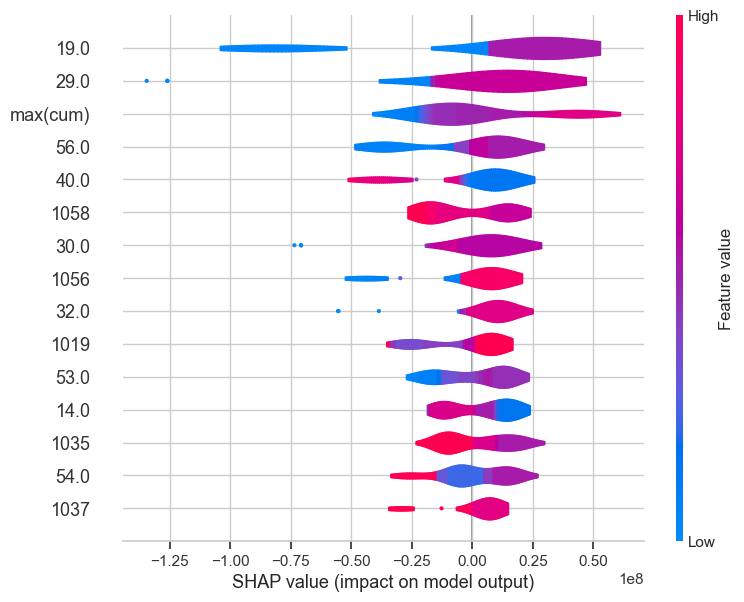

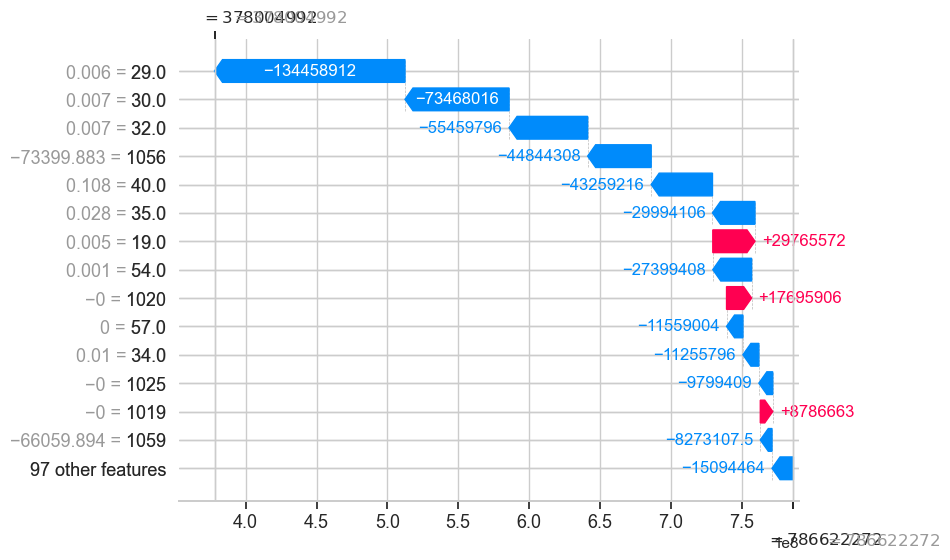

In [14]:
shap_calculations_xgb(regressor, X)

We performed two types of shap analysis an dthey are shown on the figures above (summary plot and waterfall plot)

The result of the first is shown on the summary plot (the first figure) where the dependent variables are ranked in order of importance over the whole period (1985 - 2022). The first figure shows the impact of each feature in millions of individuals. If the red colour is on the positive x-axis it indicates that more individuals of this length mean more overall individuals and vice versa. Of note is that in feature from the survey e.g. 56 blue is on the negative x axis and red on the positive side. Conversely most of the fleet catch features, 10XX show the opposite impact as expected.

The most important feature is the 19 cm feature from the surveys. This feature has always been of key importance even when our models did not manage to explain variance (<<.5) and there were higher rmse and mae errors (>100.000.000). Statistically it is easy to explain this: good recruitment means that there are a lot of individuals in the total stock (in addition to the 19cm variety). Of note is that is that 1019 has red on both sides of the of the x-axis which underlines the need to protect recruits. It is also negatively skewed.

The third feature, max(cum), is interesting in that it shows that the number of individuals caught in a survey is a very good indicator of stock size.


The rest of the important features fall into two categories: 
1)	Sizes 29-40 in caught the survey. 
2)	Sizes 35 + in caught by the fleet. 
The states the obvious: As stock is depleted the individuals caught in surveys and by the fleet are longer.


The waterfall plot n the second figure displays how the 2022 value estimation is arrived at by the regression model. the model starts at the average number of 786 m individuals (the average of stock suveys for the years 1985 - 2022) which is shown at the bottom of the figure. It then calculates the impact of the observed number of individuals in the spring survey in 2022 as well as the estimated fleet catches. The final result, 378 m,  is shown at the top of the figure and how the model got there.

### Appendix 1: Adjusting for large catches in surveys

Golden redfish lives in large schools. 

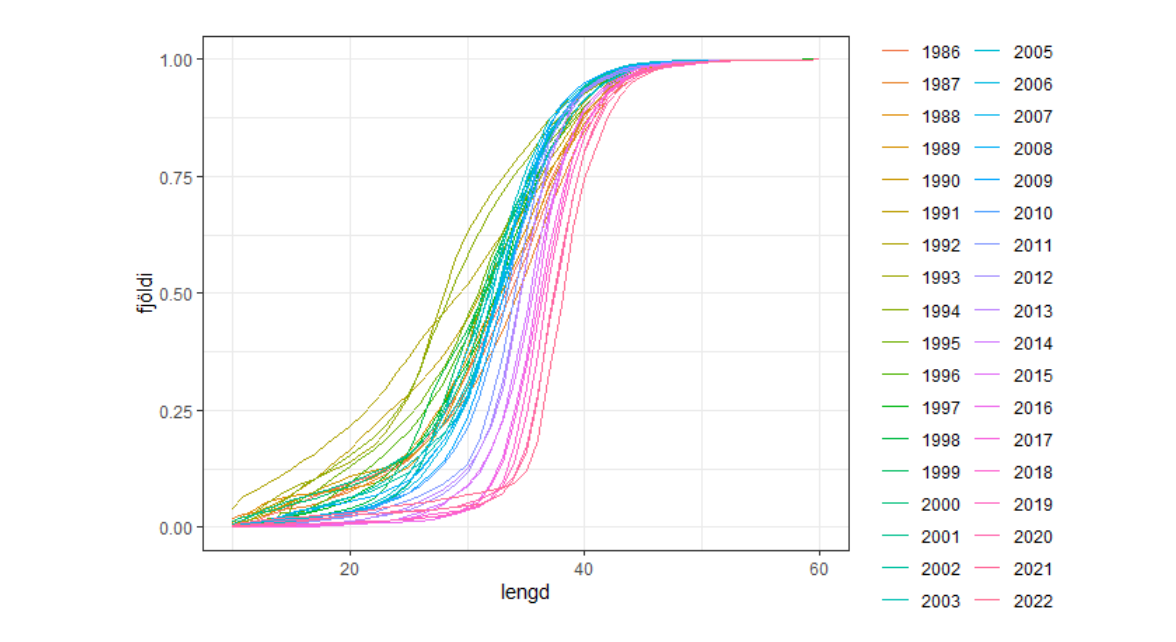{width=80%}



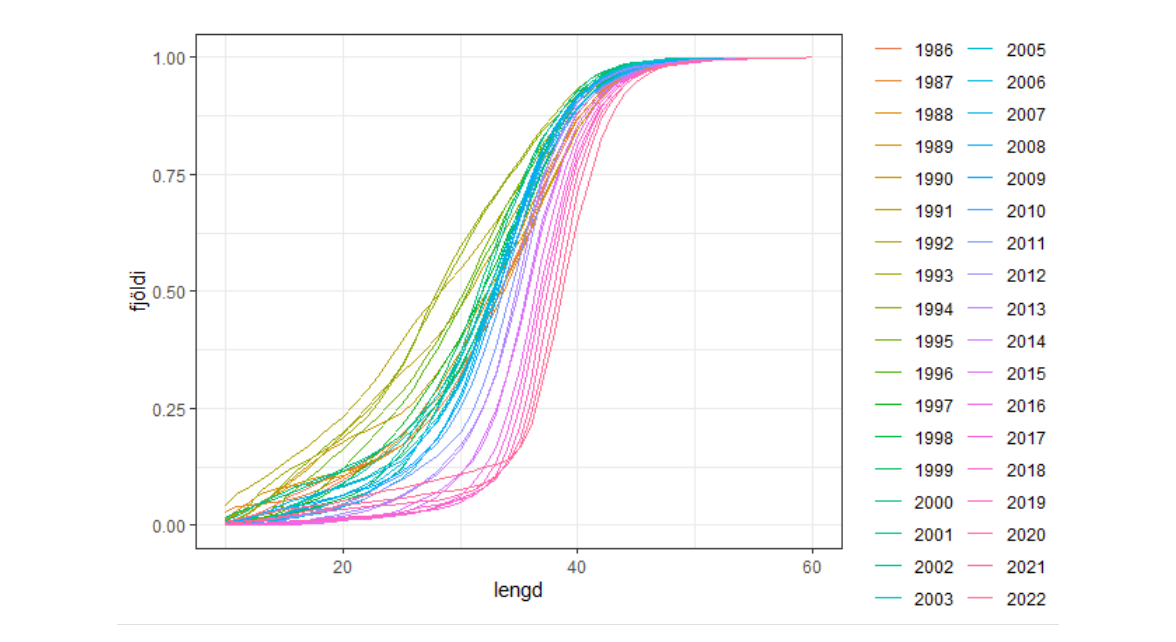{width=80%}

### Appendix 2 PCA analysis and depenency (linear or non-linear)

In [15]:
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
pca = PCA(n_components=18)
pca.fit(X_sca)

pd.options.display.float_format = '{:,.2f}'.format
evr = pd.DataFrame(pca.explained_variance_ratio_, columns=['variability'])
print(evr.iloc[0:5, 0:1])


   variability
0         0.41
1         0.23
2         0.10
3         0.05
4         0.02


The above tables illustrates that by decomposing the dependence matrix and ordering the eigenvectors by eigenvalues that almost 40% of the variability is connected to one eigenvector and that 70% of the variability can be reduced to three eigenvectors. Given that the number of dependant variables is 108 it is clear that there is a high degree of dependency between the dependant variables. Gradient boosting strength is that it discards features with the same information in already chosen features. The shap analysis above shows that the 10-15 most important features provide enough information for the model to function. 
